In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [3]:
import torch

In [5]:
rcParams.update({'font.size': 16})

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
from Flow_Perturbation.src.GMM_distribution import get_energy_device,sample_NWell

In [8]:
nsamples = 20000
ndim = 50
nwell = 10
samples, Nwellinfo = sample_NWell(nsamples, ndim, nwell)
Nwellinfo[-1] = np.ones_like(Nwellinfo[-1])
X = samples

In [9]:
ndim = X.shape[-1]

In [10]:
ndim

50

In [11]:
Nwellinfo = [torch.tensor(array, dtype=torch.float).to(device) for array in Nwellinfo]

In [12]:
dataset = torch.Tensor(X).float().reshape((-1,ndim))

In [13]:
torch.std(dataset)

tensor(1.3137)

In [14]:
device

device(type='cuda')

In [15]:
from Flow_Perturbation.src.DDPM import calc_alphas_betas, diffusion_loss_fn, diffusion_loss_fn

In [16]:
num_steps = 1000
alphas, betas, alphas_prod, alphas_bar_sqrt, one_minus_alphas_bar_sqrt = calc_alphas_betas(num_steps=num_steps, scaling=10, beta_min=1e-7, beta_max=1e-3)

In [17]:
from Flow_Perturbation.src.common import MLP_nonorm, MLP_var
from Flow_Perturbation.src.train import train_model_DDPM
model = MLP_nonorm(ndim=ndim,hidden_size=200,hidden_layers=2,emb_size=80).to(device)
batch_size = 128
dataset = dataset.to(device)
print(dataset.shape)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True)
path = 'models/GMM'
#model.load_state_dict(torch.load(f'{path}/{ndim}-d-model.pth', map_location=device))
model = train_model_DDPM(model, ndim, dataloader, path, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, num_steps,num_epoch=21,lr=2e-4, loss_DDPM = diffusion_loss_fn,decay_steps = 50)
print('Training done!')
model.eval()

torch.Size([200000, 50])
Training model...
0.9240253546721494
lr*0.5
Training done!


MLP_nonorm(
  (time_mlp): PositionalEmbedding(
    (layer): SinusoidalEmbedding()
  )
  (joint_mlp): Sequential(
    (0): Linear(in_features=130, out_features=200, bias=True)
    (1): GELU(approximate='none')
    (2): Block_nonorm(
      (ff): Linear(in_features=200, out_features=200, bias=True)
      (act): GELU(approximate='none')
    )
    (3): Block_nonorm(
      (ff): Linear(in_features=200, out_features=200, bias=True)
      (act): GELU(approximate='none')
    )
    (4): Linear(in_features=200, out_features=50, bias=True)
  )
)

In [18]:
for param in model.parameters():
    param.requires_grad = False

In [19]:
from Flow_Perturbation.src.DDPM import interpolate_parameters,DDPMSamplerCoM, DDPMSampler
st, sigma_t, st_derivative, sigma_t_derivative = interpolate_parameters(num_steps, alphas_prod)
Sampler = DDPMSampler(model, st, st_derivative, sigma_t_derivative, device)

exact_dynamics_heun = Sampler.exact_dynamics_heun
heun_torch = Sampler.heun_torch
score_function_rearange = Sampler.score_function_rearange
score_function_1element = Sampler.score_function_1element

In [20]:
from Flow_Perturbation.src.utils import  generate_tsampling

In [21]:
time_forward = generate_tsampling(1, num_steps-1, 100, 2.0)
time_backward = time_forward[::-1]

In [22]:
sampN = 1000
tmax = 1.0
lambdaT = tmax**2
xT = np.sqrt(lambdaT) * torch.randn(sampN, ndim).to(device)
x0 = exact_dynamics_heun(xT, time_backward)
Y_init = x0.cpu().detach()

In [23]:
sampN = 1000
lambdaT = tmax**2
xT = np.sqrt(lambdaT) * torch.randn(sampN, ndim).to(device)

x0 = exact_dynamics_heun(xT, time_backward)
xTp = exact_dynamics_heun(x0, time_forward)

xT - xTp

tensor([[-6.5565e-07, -4.1723e-07, -1.0729e-06,  ..., -2.0117e-07,
         -5.5879e-08,  2.1458e-06],
        [-9.5367e-07,  4.7684e-07, -4.7684e-07,  ..., -4.1723e-07,
          7.1526e-07,  8.3447e-07],
        [ 9.5367e-07, -1.4305e-06, -3.2783e-07,  ...,  0.0000e+00,
         -7.7486e-07,  1.7881e-07],
        ...,
        [ 2.1458e-06, -3.2783e-07,  1.0729e-06,  ..., -4.4703e-08,
         -5.0664e-07, -1.1921e-07],
        [ 1.1921e-07,  2.0862e-07, -1.1921e-06,  ..., -4.1723e-07,
          2.9802e-07,  1.4901e-06],
        [-9.5367e-07,  2.3842e-07, -1.3113e-06,  ...,  2.6822e-07,
          4.1723e-07,  7.1526e-07]], device='cuda:0')

In [24]:
energy_target = get_energy_device(dataset, Nwellinfo)

In [25]:
print(energy_target.mean())

tensor(66.2928, device='cuda:0')


In [26]:
print(get_energy_device(x0, Nwellinfo))

tensor([ 79.2987,  98.6932,  88.7038,  88.8245,  86.4126,  87.3479,  80.9369,
         90.4170,  84.1563,  86.7863,  80.5837,  84.3139,  89.6724,  94.7832,
         89.8919,  79.4153,  88.8554,  95.4299,  82.8790,  90.3298,  93.3375,
         75.5518,  99.5166, 107.0907,  74.9541,  88.6159,  85.6686,  82.3786,
         91.6850,  74.8287,  91.6131,  84.8880,  91.9709,  76.6356,  83.1695,
         83.4699,  80.0043,  79.2517,  78.7544,  83.2312, 100.5930,  82.4331,
         79.6921,  92.5095,  86.6481,  87.2336,  84.0630,  83.0722,  96.8826,
         84.5020,  81.7491,  87.6139,  80.1046,  88.2233,  81.1721,  86.3099,
         88.7246,  76.6132,  79.7110,  83.1344,  97.8259,  72.9791,  95.1770,
         90.1505,  86.5992,  89.5152,  89.0670,  87.4823,  75.3032,  92.8292,
         91.3545,  81.8279,  86.1007,  79.3268,  77.9386,  89.9070,  73.0983,
         81.7822,  72.6159,  74.6243,  86.0096,  89.2934,  84.7368,  93.9960,
         95.7798,  87.2252,  97.4562,  89.1739,  89.6049,  80.66

In [27]:
print(get_energy_device(x0, Nwellinfo).mean())

tensor(85.1244, device='cuda:0')


In [28]:
sampN = 10000
lambdaT = tmax**2

xT = np.sqrt(lambdaT) * torch.randn(sampN, ndim).to(device)
eps = torch.randn_like(xT)

back_coeff = 0.01
x0 = exact_dynamics_heun(xT, time_backward) + back_coeff * eps # backward dynamics

dxT = xT - exact_dynamics_heun(x0, time_forward) # this is the error in xT that needs to be matched
eps_squarenorm = torch.sum(eps**2, dim=-1)

In [29]:
from Flow_Perturbation.src.train import CustomDataset, train_model_var
from torch.utils.data import DataLoader

In [30]:
batch_size = 128
dataset = CustomDataset(x0, dxT, eps_squarenorm)
dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=True, drop_last=True)
# Create the model
model_var = MLP_var(ndim=ndim).to(device)
model_var = train_model_var(model_var, dataloader, back_coeff, num_epoch=301,lr=1e-3,path=path,decay_steps = 50)
model.eval()

0 4.29580726990333
4.29580726990333
1 1.6730109346218598
2 1.490339444233821
3 1.460317911245884
4 1.4496066937079797
5 1.384213496477176
6 1.3807962032464833
7 1.3587820866169074
8 1.337369136321239
9 1.383997345582033
10 1.4097449412712684
11 1.3872673282256494
12 1.366977566327804
13 1.3243017395337422
14 1.3014841339527032
15 1.29390654197106
16 1.2958124348750482
17 1.2870171727278295
18 1.2489801736978383
19 1.2548540142866282
20 1.2704942608490968
21 1.2820304418221498
22 1.257210740676293
23 1.243639608224233
24 1.2305933596232
25 1.2536482306627126
26 1.2667452303262858
27 1.2401773150150592
28 1.225551874209673
29 1.2709205502118819
30 1.27516104777654
31 1.2902559225375836
32 1.2187333473792443
33 1.2370082827714772
34 1.2010956421876564
35 1.1961572231390538
36 1.2551890244850745
37 1.188515141988412
38 1.1860831089508839
39 1.2264986435572307
40 1.1751813796850352
41 1.1959992012916467
42 1.2206967763411694
43 1.2745218322827265
44 1.167595346768697
45 1.1766474950007904
4

MLP_nonorm(
  (time_mlp): PositionalEmbedding(
    (layer): SinusoidalEmbedding()
  )
  (joint_mlp): Sequential(
    (0): Linear(in_features=130, out_features=200, bias=True)
    (1): GELU(approximate='none')
    (2): Block_nonorm(
      (ff): Linear(in_features=200, out_features=200, bias=True)
      (act): GELU(approximate='none')
    )
    (3): Block_nonorm(
      (ff): Linear(in_features=200, out_features=200, bias=True)
      (act): GELU(approximate='none')
    )
    (4): Linear(in_features=200, out_features=50, bias=True)
  )
)

In [31]:
for param in model_var.parameters():
    param.requires_grad = False

In [32]:
def get_log_omega(xT, eps):
    x0 = exact_dynamics_heun(xT, time_backward) + back_coeff * eps
    # forward dynamics
    # xT = exact_dynamics_heun(tmax, 0, x0, mus0, covs0) + forw_coeff * eps_tilde
    forw_coeff = model_var(x0)
    eps_tilde = (xT - exact_dynamics_heun(x0, time_forward))/forw_coeff
    deltaSt = -0.5 * torch.sum(eps_tilde**2 - eps**2, dim=-1) - ndim * torch.log(forw_coeff).squeeze(-1) + ndim * np.log(back_coeff)
    uz = torch.sum(xT**2/tmax**2, dim=-1)/2.0  + 0.5*ndim*np.log(2*np.pi) + ndim*np.log(tmax)
    ux = get_energy_device(x0, Nwellinfo)
    log_omega = -ux + deltaSt + uz

    return log_omega, x0, ux

In [33]:
# generate starting point for the MCMC move
# we need xT_init, eps_init, log_omega_init
# do the backward-forward dynamics, get deltaSt, determine forward coeff
sampN = 1000

xT_init = np.sqrt(lambdaT) * torch.randn(sampN, ndim).to(device)
eps_init = torch.randn_like(xT_init)
log_omega_init, x0_init,ux_init = get_log_omega(xT_init, eps_init)

In [34]:
'''
samples_selected = ux_init < 70
xT = xT_init[samples_selected].clone()
eps = eps_init[samples_selected].clone()
x0 = x0_init[samples_selected].clone()
log_omega = log_omega_init[samples_selected].clone()
ux = ux_init[samples_selected].clone()
'''
xT = xT_init.clone()
eps = eps_init.clone()
x0 = x0_init.clone()
log_omega = log_omega_init.clone()
ux = ux_init.clone()
print(xT.shape)


torch.Size([1000, 50])


In [35]:
from Flow_Perturbation.src.MC import get_vjp_score_mnoise, get_vjp_score, run_mcmc_and_save, get_jacobian_score, v_jacobian_score_batch,run_mcmc_and_save
from Flow_Perturbation.src.utils import generate_tsampling
v_jacobian_score = get_jacobian_score(score_function_1element)

In [36]:
K_x=5
K_eps=5

In [37]:
import os

In [38]:
if not os.path.exists('models/GMM/data_GMM'):
    os.makedirs('models/GMM/data_GMM')

In [39]:
nmcmc = 2000 # number of MCMC steps
concatenated_x0_last_steps = run_mcmc_and_save(nmcmc, ux, x0, xT, eps, log_omega, device, back_coeff,get_log_omega, 
                                                tmax=tmax, K_x=K_x, K_eps=K_eps, if_sava=False, if_eps=True,path='models/GMM/data_GMM/GMM50-FP',last_steps=100,count_last=10)

0 tensor(83.8725, device='cuda:0') tensor(633, device='cuda:0')
1 tensor(82.8181, device='cuda:0') tensor(568, device='cuda:0')
2 tensor(81.8007, device='cuda:0') tensor(533, device='cuda:0')
3 tensor(81.0354, device='cuda:0') tensor(501, device='cuda:0')
4 tensor(80.2572, device='cuda:0') tensor(470, device='cuda:0')
5 tensor(79.6050, device='cuda:0') tensor(458, device='cuda:0')
6 tensor(78.9804, device='cuda:0') tensor(446, device='cuda:0')
7 tensor(78.3180, device='cuda:0') tensor(454, device='cuda:0')
8 tensor(77.6765, device='cuda:0') tensor(461, device='cuda:0')
9 tensor(77.1240, device='cuda:0') tensor(445, device='cuda:0')
10 tensor(76.6565, device='cuda:0') tensor(432, device='cuda:0')
11 tensor(76.0816, device='cuda:0') tensor(439, device='cuda:0')
12 tensor(75.6419, device='cuda:0') tensor(402, device='cuda:0')
13 tensor(75.1912, device='cuda:0') tensor(416, device='cuda:0')
14 tensor(74.8354, device='cuda:0') tensor(423, device='cuda:0')
15 tensor(74.4349, device='cuda:0')

In [40]:
concatenated_x0_last_steps.shape

torch.Size([10000, 50])

In [41]:
Y_FP = concatenated_x0_last_steps.cpu().detach()

In [42]:
def exact_dynamics_heun_dSt_Huch(xtn1): # do a lot of Heun steps between tn and tn1 to get the accurate xtn
    ts = time_forward
    xt = xtn1 # set the initial x
    dSt = torch.zeros(xt.shape[0]).to(device) # this stores the sum of log(abs(J)) for each step
    
    eps = torch.randn_like(xt)
    _, div_xt = get_vjp_score(xt, ts[len(ts)-1], eps, score_function_rearange)
    #print(score_xt)
    for i in range(len(ts)-1, 0, -1):
        xt_new = heun_torch(xt,ts[i], ts[i-1])

        eps = torch.randn_like(xt_new)
        _, div_xt_new = get_vjp_score(xt_new, ts[i-1], eps, score_function_rearange)

        dSt += (ts[i]-ts[i-1])*(div_xt + div_xt_new)/2
        div_xt = div_xt_new
        xt = xt_new
    return xt, -dSt

def get_log_omega_J(xT, eps=None):
    x0, deltaSt = exact_dynamics_heun_dSt_Huch(xT) 
    uz = torch.sum(xT**2, dim=-1)/2.0  + 0.5*ndim*np.log(2*np.pi)
    ux = get_energy_device(x0, Nwellinfo)
    log_omega = -ux + deltaSt + uz

    return log_omega, x0, ux

In [43]:

sampN = 1000

xT_init = np.sqrt(lambdaT) * torch.randn(sampN, ndim).to(device)
eps_init = torch.randn_like(xT_init)

log_omega_init, x0_init,ux_init = get_log_omega_J(xT_init, eps_init)

In [44]:
xT = xT_init.clone()
eps = eps_init.clone()
x0 = x0_init.clone()
log_omega = log_omega_init.clone()
ux = ux_init.clone()

In [45]:
'''
samples_selected = ux_init < 70
xT = xT_init[samples_selected].clone()
eps = eps_init[samples_selected].clone()
x0 = x0_init[samples_selected].clone()
log_omega = log_omega_init[samples_selected].clone()
ux = ux_init[samples_selected].clone()
'''
xT = xT_init.clone()
eps = eps_init.clone()
x0 = x0_init.clone()
log_omega = log_omega_init.clone()
ux = ux_init.clone()
print(xT.shape)

torch.Size([1000, 50])


In [46]:
nmcmc = 2000 # number of MCMC steps
concatenated_x0_last_steps = run_mcmc_and_save(nmcmc, ux, x0, xT, eps, log_omega, device, back_coeff,get_log_omega_J, 
                                                tmax=tmax, K_x=K_x, K_eps=K_eps,if_sava=False, if_eps=False,path='models/GMM/data_GMM/GMM50-H1',last_steps=100,count_last=10)

0 tensor(84.1290, device='cuda:0') tensor(627, device='cuda:0')
1 tensor(82.9624, device='cuda:0') tensor(570, device='cuda:0')
2 tensor(82.0429, device='cuda:0') tensor(517, device='cuda:0')
3 tensor(81.1476, device='cuda:0') tensor(532, device='cuda:0')
4 tensor(80.2831, device='cuda:0') tensor(487, device='cuda:0')
5 tensor(79.5730, device='cuda:0') tensor(496, device='cuda:0')
6 tensor(78.8809, device='cuda:0') tensor(509, device='cuda:0')
7 tensor(78.2962, device='cuda:0') tensor(490, device='cuda:0')
8 tensor(77.5658, device='cuda:0') tensor(465, device='cuda:0')
9 tensor(76.9575, device='cuda:0') tensor(450, device='cuda:0')
10 tensor(76.5174, device='cuda:0') tensor(415, device='cuda:0')
11 tensor(76.0875, device='cuda:0') tensor(425, device='cuda:0')
12 tensor(75.6771, device='cuda:0') tensor(396, device='cuda:0')
13 tensor(75.3988, device='cuda:0') tensor(403, device='cuda:0')
14 tensor(75.0213, device='cuda:0') tensor(418, device='cuda:0')
15 tensor(74.5581, device='cuda:0')

In [47]:
Y_H1 = concatenated_x0_last_steps.cpu().detach()

In [48]:
def exact_dynamics_heun_dSt_Huch(xtn1): # do a lot of Heun steps between tn and tn1 to get the accurate xtn
    ts = time_forward
    xt = xtn1 # set the initial x
    dSt = torch.zeros(xt.shape[0]).to(device) # this stores the sum of log(abs(J)) for each step
    nnoise = 10 # we want to average over 10 noises
    eps = torch.randn((nnoise, xt.shape[0], xt.shape[1])).to(device)
    _, div_xt = get_vjp_score_mnoise(xt, ts[len(ts)-1], eps, score_function_rearange)
    for i in range(len(ts)-1, 0, -1):
        xt_new = heun_torch(xt,ts[i], ts[i-1])

        eps = torch.randn((nnoise, xt.shape[0], xt.shape[1])).to(device)
        _, div_xt_new = get_vjp_score_mnoise(xt_new, ts[i-1], eps, score_function_rearange)

        dSt += (ts[i]-ts[i-1])*(div_xt + div_xt_new)/2
        
        div_xt = div_xt_new
        xt = xt_new
    return xt, -dSt

 
def get_log_omega_J(xT, eps=None):
    x0, deltaSt = exact_dynamics_heun_dSt_Huch(xT) 
    uz = torch.sum(xT**2, dim=-1)/2.0  + 0.5*ndim*np.log(2*np.pi)
    ux = get_energy_device(x0, Nwellinfo)
    log_omega = -ux + deltaSt + uz

    return log_omega, x0, ux

In [49]:
sampN = 1000

xT_init = np.sqrt(lambdaT) * torch.randn(sampN, ndim).to(device)
eps_init = torch.randn_like(xT_init)

log_omega_init, x0_init,ux_init = get_log_omega_J(xT_init, eps_init)

In [50]:
xT = xT_init.clone()
eps = eps_init.clone()
x0 = x0_init.clone()
log_omega = log_omega_init.clone()
ux = ux_init.clone()

In [51]:
'''
samples_selected = ux_init < 70
xT = xT_init[samples_selected].clone()
eps = eps_init[samples_selected].clone()
x0 = x0_init[samples_selected].clone()
log_omega = log_omega_init[samples_selected].clone()
ux = ux_init[samples_selected].clone()
'''
xT = xT_init.clone()
eps = eps_init.clone()
x0 = x0_init.clone()
log_omega = log_omega_init.clone()
ux = ux_init.clone()
print(xT.shape)

torch.Size([1000, 50])


In [52]:
nmcmc = 2000 # number of MCMC steps
concatenated_x0_last_steps = run_mcmc_and_save(nmcmc, ux, x0, xT, eps, log_omega, device, back_coeff,get_log_omega_J, 
                                                    tmax=tmax, K_x=K_x, K_eps=K_eps, if_sava=False, if_eps=False,path='models/GMM/data_GMM/GMM50-H10',last_steps=100,count_last=10)

0 tensor(83.9356, device='cuda:0') tensor(634, device='cuda:0')
1 tensor(82.7420, device='cuda:0') tensor(592, device='cuda:0')
2 tensor(81.7575, device='cuda:0') tensor(534, device='cuda:0')
3 tensor(80.8191, device='cuda:0') tensor(507, device='cuda:0')
4 tensor(79.9517, device='cuda:0') tensor(503, device='cuda:0')
5 tensor(79.1670, device='cuda:0') tensor(465, device='cuda:0')
6 tensor(78.5447, device='cuda:0') tensor(443, device='cuda:0')
7 tensor(77.9574, device='cuda:0') tensor(434, device='cuda:0')
8 tensor(77.3182, device='cuda:0') tensor(467, device='cuda:0')
9 tensor(76.7851, device='cuda:0') tensor(439, device='cuda:0')
10 tensor(76.2917, device='cuda:0') tensor(435, device='cuda:0')
11 tensor(75.8257, device='cuda:0') tensor(425, device='cuda:0')
12 tensor(75.4089, device='cuda:0') tensor(427, device='cuda:0')
13 tensor(75.0133, device='cuda:0') tensor(399, device='cuda:0')
14 tensor(74.5491, device='cuda:0') tensor(397, device='cuda:0')
15 tensor(74.2309, device='cuda:0')

In [53]:
Y_H10 = concatenated_x0_last_steps.cpu().detach()


In [54]:
def exact_dynamics_heun_dSt(xtn1): # do a lot of Heun steps between tn and tn1 to get the accurate xtn
    ts = time_forward
    xt = xtn1
    dSt = torch.zeros(xt.shape[0]).to(device) # this stores the sum of log(abs(J)) for each step
    
    jj_score_xt = v_jacobian_score(xt, ts[len(ts)-1]).to(device)
    div_xt = torch.einsum("...ii", jj_score_xt)
    for i in range(len(ts)-1, 0, -1):
        xt_new = heun_torch(xt,ts[i], ts[i-1])
        jj_score_xt_new = v_jacobian_score(xt_new, ts[i-1]).to(device)
        div_xt_new = torch.einsum("...ii", jj_score_xt_new)
        dSt += (ts[i]-ts[i-1])*(div_xt + div_xt_new)/2
        div_xt = div_xt_new
        xt = xt_new
        del xt_new,jj_score_xt_new,div_xt_new
    return xt, -dSt

def get_log_omega_J(xT, eps=None):
    x0, deltaSt = exact_dynamics_heun_dSt(xT) 
    #print(x0.shape)
    uz = torch.sum(xT**2, dim=-1)/2.0  + 0.5*ndim*np.log(2*np.pi)
    ux = get_energy_device(x0, Nwellinfo)
    log_omega = -ux + deltaSt + uz

    return log_omega, x0, ux

In [55]:

sampN = 1000

xT_init = np.sqrt(lambdaT) * torch.randn(sampN, ndim).to(device)
eps_init = torch.randn_like(xT_init)

log_omega_init, x0_init,ux_init = get_log_omega_J(xT_init, eps_init)

In [56]:
xT = xT_init.clone()
eps = eps_init.clone()
x0 = x0_init.clone()
log_omega = log_omega_init.clone()
ux = ux_init.clone()

In [57]:
'''
samples_selected = ux_init < 70
xT = xT_init[samples_selected].clone()
eps = eps_init[samples_selected].clone()
x0 = x0_init[samples_selected].clone()
log_omega = log_omega_init[samples_selected].clone()
ux = ux_init[samples_selected].clone()
'''
xT = xT_init.clone()
eps = eps_init.clone()
x0 = x0_init.clone()
log_omega = log_omega_init.clone()
ux = ux_init.clone()
print(xT.shape)

torch.Size([1000, 50])


In [58]:
nmcmc = 500 # number of MCMC steps
concatenated_x0_last_steps = run_mcmc_and_save(nmcmc, ux, x0, xT, eps, log_omega, device, back_coeff,get_log_omega_J, 
                                                tmax=tmax, K_x=K_x, K_eps=K_eps, if_sava=False, if_eps=False,path='models/GMM/data_GMM/GMM50-J',last_steps=100,count_last=10)

0 tensor(84.1704, device='cuda:0') tensor(619, device='cuda:0')
1 tensor(83.0393, device='cuda:0') tensor(572, device='cuda:0')
2 tensor(82.1726, device='cuda:0') tensor(542, device='cuda:0')
3 tensor(81.3287, device='cuda:0') tensor(521, device='cuda:0')
4 tensor(80.4827, device='cuda:0') tensor(498, device='cuda:0')
5 tensor(79.8203, device='cuda:0') tensor(495, device='cuda:0')
6 tensor(79.2004, device='cuda:0') tensor(468, device='cuda:0')
7 tensor(78.5156, device='cuda:0') tensor(478, device='cuda:0')
8 tensor(77.9937, device='cuda:0') tensor(457, device='cuda:0')
9 tensor(77.5259, device='cuda:0') tensor(430, device='cuda:0')
10 tensor(77.0122, device='cuda:0') tensor(414, device='cuda:0')
11 tensor(76.3180, device='cuda:0') tensor(446, device='cuda:0')
12 tensor(75.7662, device='cuda:0') tensor(449, device='cuda:0')
13 tensor(75.2756, device='cuda:0') tensor(408, device='cuda:0')
14 tensor(74.8894, device='cuda:0') tensor(412, device='cuda:0')
15 tensor(74.5208, device='cuda:0')

In [59]:
Y_J = concatenated_x0_last_steps.cpu().detach()


In [60]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)  # reducing to 2D for visualization

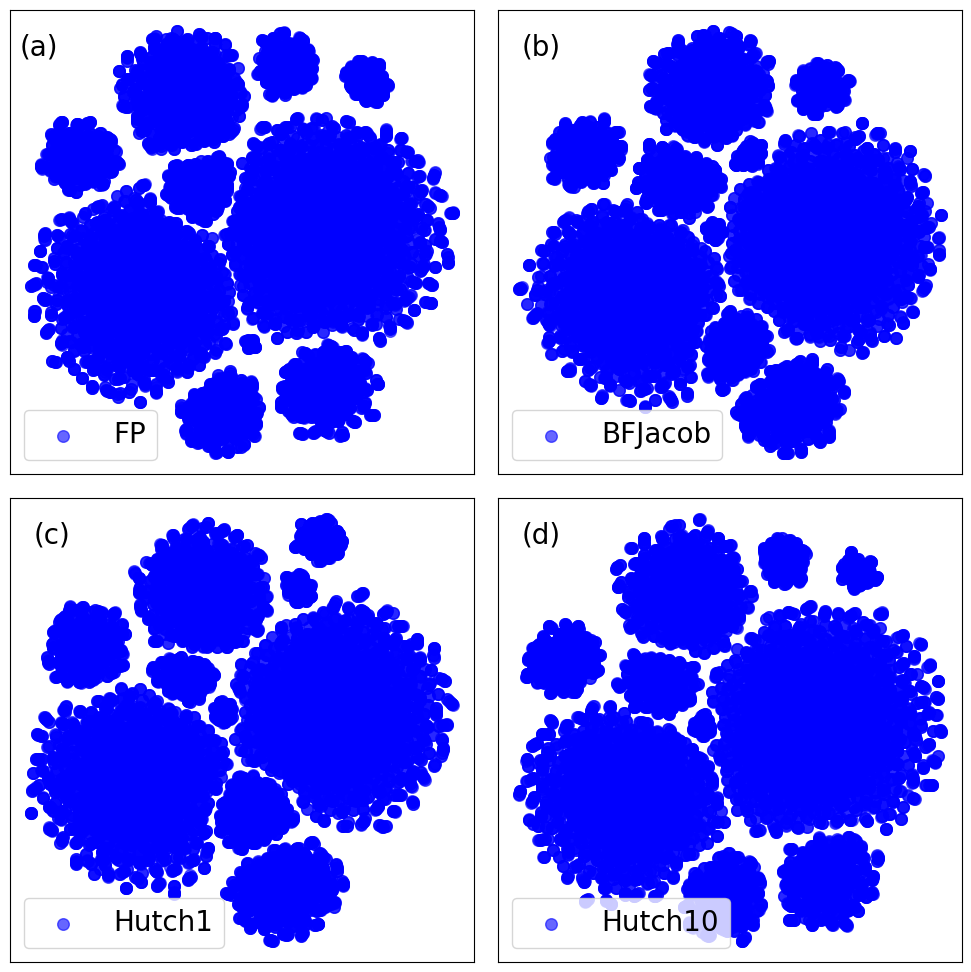

In [61]:

X_tsne_init = tsne.fit_transform(Y_init)
X_tsne_J = tsne.fit_transform(Y_J)
X_tsne_u = tsne.fit_transform(Y_FP)
X_tsne_one = tsne.fit_transform(Y_H1)
X_tsne_ten = tsne.fit_transform(Y_H10)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].scatter(X_tsne_u[:, 0], X_tsne_u[:, 1],  color='blue', s=70, alpha=0.6, label='FP')
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])
axs[0, 0].legend(loc='lower left', bbox_to_anchor=(0, 0), fontsize=20)

axs[0, 1].scatter(X_tsne_J[:, 0], X_tsne_J[:, 1],  color='blue', s=70, alpha=0.6, label='BFJacob')
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].legend(loc='lower left', bbox_to_anchor=(0, 0), fontsize=20)

axs[1, 0].scatter(X_tsne_one[:, 0], X_tsne_one[:, 1],  color='blue', s=70, alpha=0.6, label='Hutch1')
axs[1, 0].set_xticks([])
axs[1, 0].set_yticks([])
axs[1, 0].legend(loc='lower left', bbox_to_anchor=(0, 0), fontsize=20)

axs[1, 1].scatter(X_tsne_ten[:, 0], X_tsne_ten[:, 1],  color='blue', s=70, alpha=0.6, label='Hutch10')
axs[1, 1].set_xticks([])
axs[1, 1].set_yticks([])
axs[1, 1].legend(loc='lower left', bbox_to_anchor=(0, 0), fontsize=20)
axs[0, 0].text(0.02, 0.95, '(a)', horizontalalignment='left', verticalalignment='top', transform=axs[0, 0].transAxes, fontsize=20)
axs[0, 1].text(0.05, 0.95, '(b)', horizontalalignment='left', verticalalignment='top', transform=axs[0, 1].transAxes, fontsize=20)
axs[1, 0].text(0.05, 0.95, '(c)', horizontalalignment='left', verticalalignment='top', transform=axs[1, 0].transAxes, fontsize=20)
axs[1, 1].text(0.05, 0.95, '(d)', horizontalalignment='left', verticalalignment='top', transform=axs[1, 1].transAxes, fontsize=20)
plt.tight_layout()
plt.savefig('figures/1000-tsne.png', bbox_inches='tight')

In [62]:
ux = get_energy_device(Y_init, Nwellinfo)
ux_J = get_energy_device(Y_J, Nwellinfo)
ux_FP = get_energy_device(Y_FP, Nwellinfo)
ux_H1 = get_energy_device(Y_H1, Nwellinfo)
ux_H10 = get_energy_device(Y_H10, Nwellinfo)

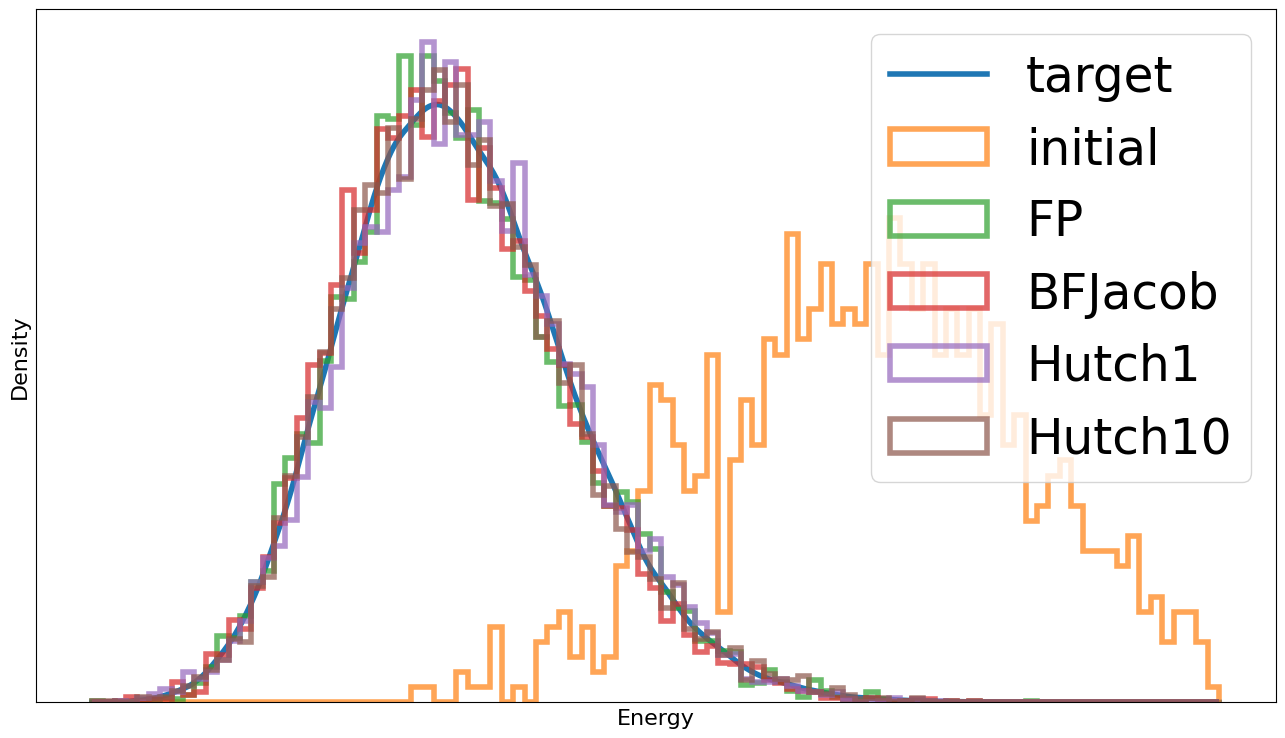

In [63]:
from scipy.stats import gaussian_kde

kde = gaussian_kde(energy_target.cpu().numpy())
x_range = np.linspace(50, 100, 1000)
kde_values = kde(x_range)

plt.figure(figsize=(16, 9))
plt.plot(x_range, kde_values, label='target', linewidth=4)

plt.hist(ux.cpu().numpy(), alpha=0.7, bins=np.linspace(50, 100, 100), label='initial', density=True, histtype='step', linewidth=4)
plt.hist(ux_FP.cpu().numpy(), alpha=0.7, bins=np.linspace(50, 100, 100), label='FP', density=True, histtype='step', linewidth=4)
plt.hist(ux_J.cpu().numpy(), alpha=0.7, bins=np.linspace(50, 100, 100), label='BFJacob', density=True, histtype='step', linewidth=4)
plt.hist(ux_H1.cpu().numpy(), alpha=0.7, bins=np.linspace(50, 100, 100), label='Hutch1', density=True, histtype='step', linewidth=4)
plt.hist(ux_H10.cpu().numpy(), alpha=0.7, bins=np.linspace(50, 100, 100), label='Hutch10', density=True, histtype='step', linewidth=4)
plt.legend(fontsize=35)
plt.xlabel("Energy")
plt.ylabel("Density")

plt.xticks([])
plt.yticks([])
#plt.savefig('figures/different_methods1000-kde.png', bbox_inches='tight')
plt.show()

In [64]:
path = 'models/GMM/data_GMM/GMM50'

In [65]:
energy_FP = torch.load(f'{path}-FP-energy-{back_coeff}-{K_x}-{K_eps}.pt')
energy_J = torch.load(f'{path}-J-energy-{back_coeff}-{K_x}-{K_eps}.pt')
energy_H1 = torch.load(f'{path}-H1-energy-{back_coeff}-{K_x}-{K_eps}.pt')
energy_H10 = torch.load(f'{path}-H10-energy-{back_coeff}-{K_x}-{K_eps}.pt')

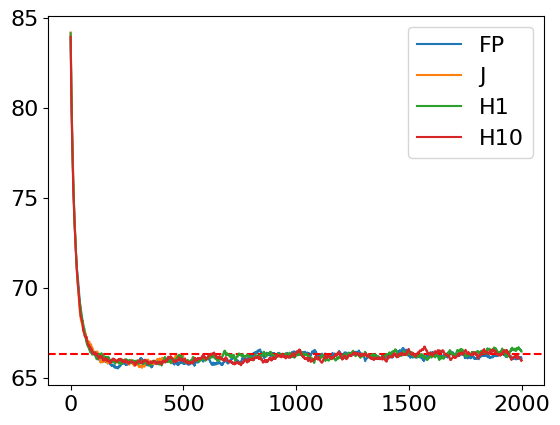

In [66]:

plt.plot(energy_FP, label='FP')
plt.plot(energy_J, label='J')
plt.axhline(y=energy_target.mean().cpu(), color='r', linestyle='--')
plt.plot(energy_H1, label='H1')
plt.plot(energy_H10, label='H10')
#plt.xlim(0, 10000)
plt.legend()